# KNN Depth Regression
I'll load the imagery that was preprocessed [here](ImageryPreprocessing.ipynb) and apply the KNN depth regression.

In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd
from OpticalRS import *
from OpticalRS.ArrayUtils import band_df
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../data

/home/jkibele/Copy/JobStuff/PhD/iPythonNotebooks/DepthPaper/data


In [3]:
imrds = RasterDS('Leigh_wv2_denoised.tif')
imarr = imrds.band_array
deprds = RasterDS('Leigh_Depth_atAcq_Resampled.tif')
darr = -1 * deprds.band_array.squeeze()

## Depth Restriction
I'm going to restrict this exercise to depths less than 20m.

In [4]:
darr = np.ma.masked_greater( darr, 20.0 )

I want to make the masks match on my data sets so that the unmasked pixels will line up correctly.

In [5]:
imarr = ArrayUtils.mask3D_with_2D( imarr, darr.mask )
darr = np.ma.masked_where( imarr[...,0].mask, darr )

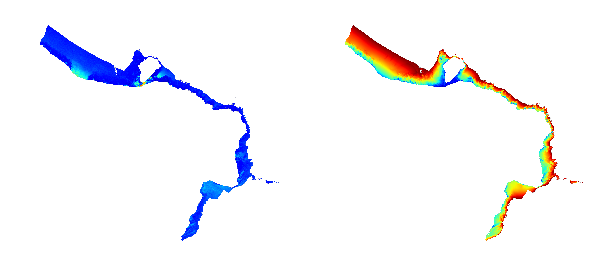

In [6]:
fig,(ax1,ax2) = subplots(1,2,figsize=(10,5))
ax1.imshow( imarr[...,1],norm=mpl.colors.LogNorm())
ax2.imshow( darr )
blah = [ax.set_axis_off() for ax in (ax1,ax2)]

In [19]:
darr.count(), darr.min(), darr.max()

(644953, 1.4282515, 19.998253)

Split data into training and test sets.

In [8]:
x_train, x_test, y_train, y_test = train_test_split( \
            imarr.compressed().reshape(-1,8),darr.compressed(), \
            train_size=300000,random_state=5)

In [9]:
knn = KNeighborsRegressor()
knn.fit( x_train, y_train )
pred = knn.predict( x_test )

In [10]:
knn.score( x_test, y_test )

0.86537237221290242

### Trained and Tested on Depth Limited Data

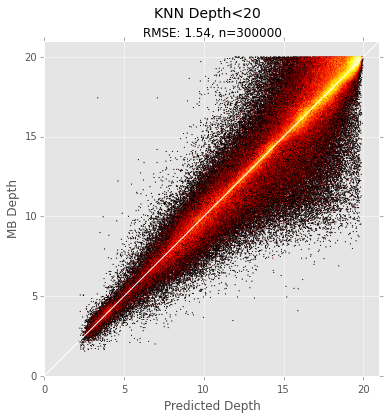

In [11]:
dlimit = 20.0
fig2,ax = plt.subplots(1,1,figsize=(6,6))
ax.hexbin(pred,y_test,mincnt=1,gridsize=500,bins='log',cmap=plt.cm.hot)
# ax.scatter(pred3,y3_test,alpha=0.008,edgecolor='none')
ax.set_ylabel('MB Depth')
ax.set_xlabel('Predicted Depth')
rmse = np.sqrt( mean_squared_error( y_test, pred ) )
n = x_train.shape[0]
tit = "RMSE: %.2f, n=%i" % (rmse,n)
ax.set_title(tit,fontsize=12)
ax.set_aspect('equal')
ax.axis([0,dlimit+1,0,dlimit+1])
ax.plot([0,dlimit+1],[0,dlimit+1],c='white')
fig2.suptitle('KNN Depth<20',fontsize=14)

In [12]:
preddf = pd.DataFrame({'prediction':pred,'mb_depth':y_test})
# preddf.to_pickle('KNN20mPredVsMB.pkl')

(-12, 12)

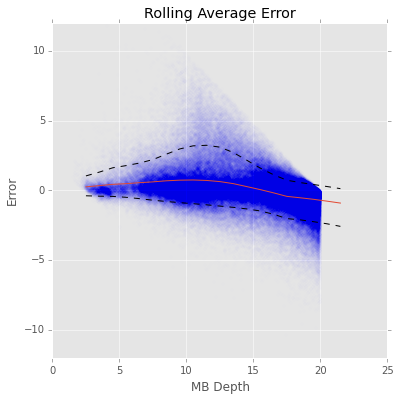

In [13]:
resdf = preddf.copy()
resdf['error'] = resdf.prediction - resdf.mb_depth
errlist,upp95,low95 = [],[],[]
ds = arange(2.5,32.5,1)
for d in ds:
    ld,hd = d-2.5, d+2.5
#     print d, ld, hd, resdf.query('mb_depth > %i and mb_depth < %i' % (ld,hd)).count()
    errs = resdf.query('mb_depth > %i and mb_depth < %i' % (ld,hd)).error
    upp95.append( errs.quantile(0.90) )
    low95.append( errs.quantile(0.10) )
    errlist.append( errs.mean() )
fig,ax = subplots(1,1,figsize=(6,6))
ax.plot(ds,errlist)
ax.plot(ds,upp95,c='k',linestyle='--')
ax.plot(ds,low95,c='k',linestyle='--')
ax.scatter(resdf.mb_depth,resdf.error,alpha=0.005)
ax.set_title("Rolling Average Error")
ax.set_xlabel("MB Depth")
ax.set_ylabel("Error")
ax.set_ylim(-12,12)

## Full 20m Limited Prediction

In [14]:
full_pred = knn.predict( imarr.compressed().reshape(-1,8) )

In [15]:
fullpredout = imarr[...,0].copy()
fullpredout[~darr.mask] = full_pred

In [16]:
fullprederr = fullpredout - darr

In [17]:
fullpredout.dump('KNNPred.pkl')
fullprederr.dump('KNNPredErr.pkl')

<matplotlib.colorbar.Colorbar instance at 0x7fb3fbca7f80>

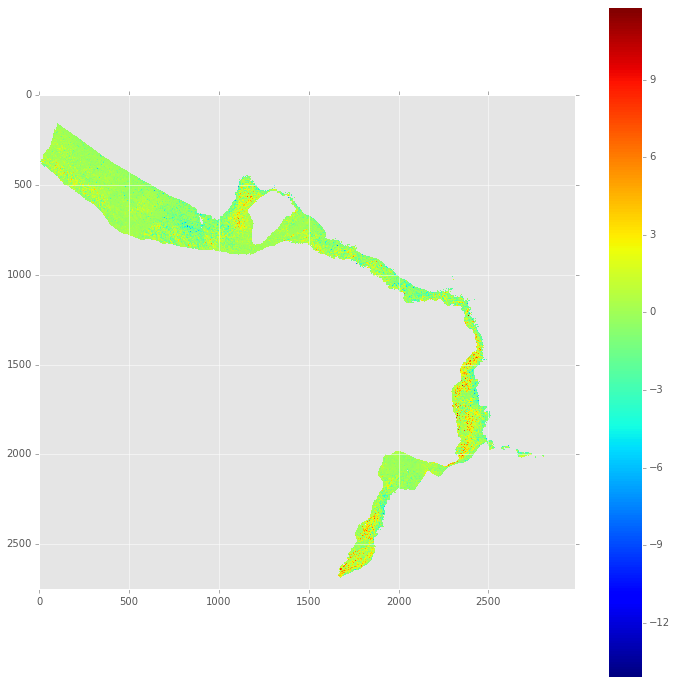

In [18]:
figure(figsize=(12,12))
imshow( fullprederr,interpolation='nearest' )
colorbar()

### Effect of Depth Limit on Model Accuracy
Given a fixed number of training points (n=1500), what is the effect of limiting the depth of the model.

In [42]:
fullim = imrds.band_array
fulldep = -1 * deprds.band_array.squeeze()

In [43]:
fullim = ArrayUtils.mask3D_with_2D( fullim, fulldep.mask )
fulldep = np.ma.masked_where( fullim[...,0].mask, fulldep )

In [44]:
fulldep.max()

36.888248

In [45]:
dlims = arange(5,31,2.5)
drmses,meanerrs,stderrs = [],[],[]
for dl in dlims:
    dlarr = np.ma.masked_greater( fulldep, dl )
    iml = ArrayUtils.mask3D_with_2D( fullim, dlarr.mask )
    xl_train, xl_test, yl_train, yl_test = train_test_split( \
            iml.compressed().reshape(-1,8),dlarr.compressed(),train_size=1500,random_state=5)
    knnl = KNeighborsRegressor()
    predl = knnl.fit( xl_train, yl_train ).predict( xl_test )
    drmses.append( sqrt( mean_squared_error(yl_test,predl) ) )
    meanerrs.append( (yl_test - predl).mean() )
    stderrs.append( (yl_test - predl).std() )

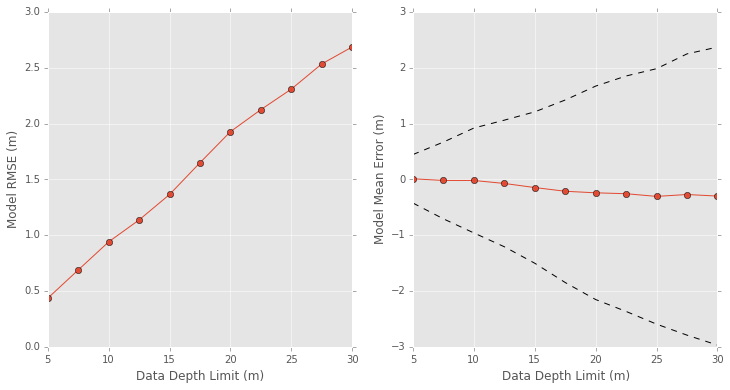

In [46]:
fig,(ax1,ax2) = subplots(1,2,figsize=(12,6))
ax1.plot(dlims,np.array(drmses),marker='o')
ax1.set_xlabel("Data Depth Limit (m)")
ax1.set_ylabel("Model RMSE (m)")
em,es = np.array(meanerrs), np.array(stderrs)
ax2.plot(dlims,em,marker='o')
ax2.plot(dlims,em+es,linestyle='--',c='k')
ax2.plot(dlims,em-es,linestyle='--',c='k')
ax2.set_xlabel("Data Depth Limit (m)")
ax2.set_ylabel("Model Mean Error (m)")

In [47]:
deplimdf = pd.DataFrame({'depth_lim':dlims,'rmse':drmses,'mean_error':meanerrs,'standard_error':stderrs})

In [48]:
deplimdf.to_pickle('KNNDepthLimitDF.pkl')

## Limited Training Data
What happens to the accuracy as the number of training points is decreased? Here the depth limit is held at 20m.

In [8]:
ns = np.logspace(1,log10(0.8*darr.count()),15)
ltdf = pd.DataFrame({'train_size':ns})
for rs in range(10):
    nrmses = []
    for n in ns:
        xn_train,xn_test,yn_train,yn_test = train_test_split( \
            imarr.compressed().reshape(-1,8),darr.compressed(),train_size=int(n),random_state=rs)
        knn_n = KNeighborsRegressor()
        npred = knn_n.fit(xn_train,yn_train).predict(xn_test)
        nrmses.append( sqrt( mean_squared_error(yn_test,npred ) ) )
    dflabel = 'rand_state_%i' % rs
    ltdf[dflabel] = nrmses
print "min points: %i, max points: %i" % (int(ns.min()),int(ns.max()))

min points: 10, max points: 515962


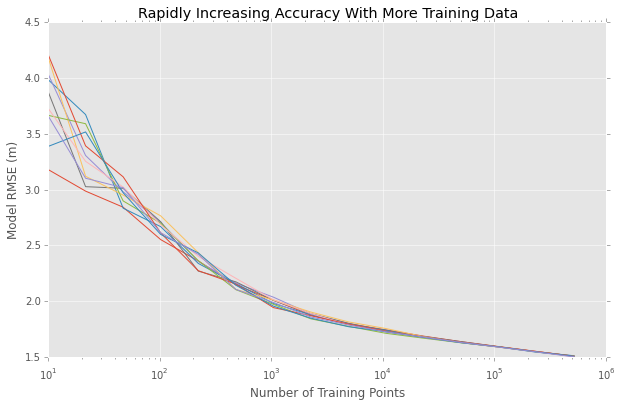

In [9]:
fig,ax = subplots(1,1,figsize=(10,6))
for rs in range(10):
    dflabel = 'rand_state_%i' % rs
    ax.plot(ltdf['train_size'],ltdf[dflabel])
ax.set_xlabel("Number of Training Points")
ax.set_ylabel("Model RMSE (m)")
# ax.set_xlim(0,5000)
ax.set_xscale('log')
ax.set_title("Rapidly Increasing Accuracy With More Training Data")

In [11]:
ltdf.to_pickle('KNNAccuracyDF.pkl')